In [ ]:
#@title Install Transformers
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
#@title Instantiate the CLIP Seg Model
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [ ]:
#@title Upload Image Data File from https://raw.githubusercontent.com/NikhilVinay04/SAiDL2023-assignment-Nikhil-Vinay/main/Q4-Image-Segmentation/image_data_split.json
import json
from google.colab import files

uploaded = files.upload()


Saving image_data_split[1].json to image_data_split[1].json


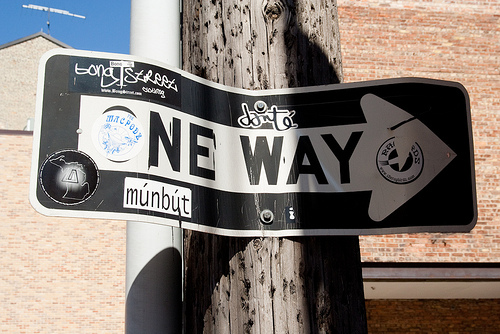

In [ ]:
#@title Open a random image from Phrasecut dataset; opens a new image everytime this block is executed
from PIL import Image
import requests
import json
import random

json_file = open('image_data_split[1].json')
imgdata = json.load(json_file)
imagid = random.randint(0,78000)

#url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
url = imgdata[imagid]['url']
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
#@title Prompt with text categories to segment the image
prompts = ["black", "white", "sign", "trunk","brick","pipe","blue"]

In [ ]:
#@title Input the Image and the text prompt to the CLIP Seg Model
import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

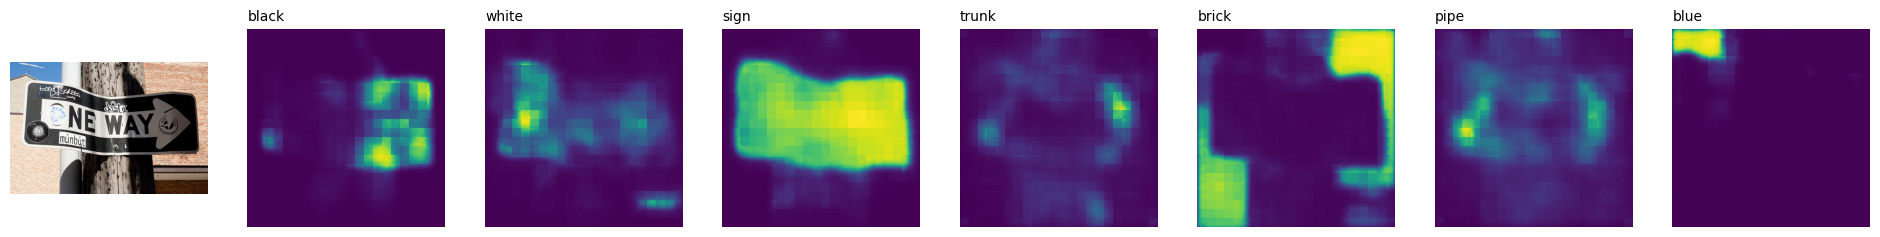

In [ ]:
#@title Visualise the output
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];